In [1]:
# !pip install selenium
# !pip install webdriver-manager
# !pip install bs4
# !pip install xgboost
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from lime.lime_tabular import LimeTabularExplainer
import requests
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
from unidecode import unidecode
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# data_true_location_eliel = '~/Downloads/DHDS/TP Final/git_fake_news/data/True.csv'
# data_fake_location_eliel = '~/Downloads/DHDS/TP Final/git_fake_news/data/Fake.csv'
# # data_true_location_lucas = 'C:\\Users\\Lucas Choconi\\Documents\\DH\\Datasets\\fakenews\True.csv'
# # data_fake_location_lucas = 'C:\\Users\\Lucas Choconi\\Documents\\DH\\Datasets\\fakenews\Fake.csv'
# # data_true_location_ger = ''
# # data_fake_location_ger = ''

In [3]:
# Dataset from https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
file_names_true = pd.read_csv('./data/True.csv')
file_names_true['real'] = 'True'
file_names_fake = pd.read_csv('./data/Fake.csv')
file_names_fake['real'] = 'Fake'
data = file_names_fake.append(file_names_true, ignore_index=True)
data.head(1)

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake


In [ ]:
# Trabar 1ero con texto y después con el título

In [4]:
# Unimos el título y el contenido del artículo en una sola columna
data['text'] = data['title'] + ' --- ' + data['text'] 
with pd.option_context('display.max_colwidth', None):
  display(data.head(1))
data = data.drop(columns = 'title')

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing --- Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",Fake


In [5]:
# Algunas filas contienen datos erróneos que impiden transformar la columna 'date' a formato fecha
wrong_row = data['date'] == 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
data[wrong_row]

,text,subject,date,real
9358,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake


In [6]:
# Las filas que no pueden ser correctamente transformadas a datetime serán utilizadas en una máscara booleana
# para poder eliminarlas
data['date'] = data['date'].apply(lambda x: pd.to_datetime(x, infer_datetime_format = True)\
                                                           if re.search('[a-z-A-Z]+ [0-9]+, [0-9]{4}', x) else
                                                            'delete')
delete_mask = data['date'] != 'delete'
data = data[delete_mask]
data = data.reset_index()
data['date'] = data['date'].astype('datetime64')

In [8]:
# Separamos los datos en las filas que contienen noticias falsas de las que son reales
data_real = data[data['real'] == 'True']

data_fake = data[data['real'] == 'Fake']

In [ ]:
# Averiguamos cuál es el largo promedio de las noticias falsas y de las reales y hacemos un gráfico comparativo
#data['text_len'] = data['text'].apply(lambda x: len(word_tokenize(x)))
#real_len_avg = data_real['text_len'].mean()
#fake_len_avg = data_fake['text_len'].mean()
#len_avgs = [real_len_avg, fake_len_avg]
#plt.bar(['Real', 'Fake'], len_avgs)

In [ ]:
'''
# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt
all_eng_words = pd.read_csv('./data/all_english_words.csv')
all_eng_words = pd.Series(all_eng_words.iloc[:,0])
all_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)

def words_percentage(text):
    # Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] 
    words_in_dict = [word for word in words if word in all_eng_words.values]
    words_in_dict_percentage = len(words_in_dict) * 100 / len(words)
    return words_in_dict_percentage

tqdm.pandas()
data['words_in_dict_pct'] = data['text'].progress_apply(words_percentage)
'''
'''Esta celda demora 35hs en ejecutarse.'''

<AxesSubplot:xlabel='subject', ylabel='Count'>

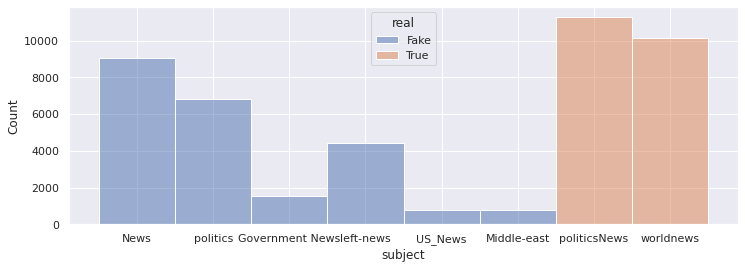

In [9]:
sns.set(rc={'figure.figsize':(12, 4)})
sns.histplot(data = data, x = 'subject', hue = 'real')

In [10]:
# Como hay valores diferentes en la columna "subject" para las noticias reales y las falsas borramos esa columna
data = data.drop(columns = 'subject')

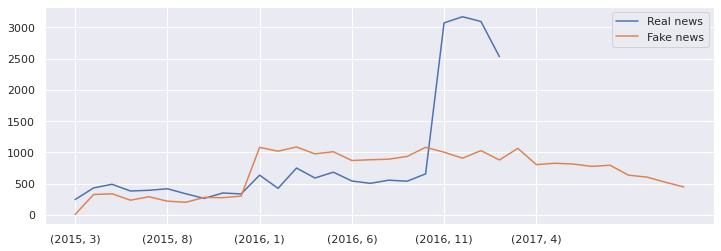

In [11]:
# Hacemos un gráfico mostrando el conteo de cuántas noticias falsas y cuántas verdaderas se publicaron 
# por mes en el dataset 
ax = data_real['date'].groupby([data_real["date"].dt.year, data_real["date"].dt.month]).count().plot.line(label = 'Real news')
ax = data_fake['date'].groupby([data_fake["date"].dt.year, data_fake["date"].dt.month]).count().plot.line(label = 'Fake news')
ax.set(xlabel=None)
ax.legend()

El pico de noticias verdaderas publicadas en Noviembre del 2016 coincide con las elecciones presidenciales de Estados Unidos

In [12]:
# El dataset no valores nulos así que damos for finalizada la limpieza
data.isna().sum()

index    0
text     0
date     0
real     0
dtype: int64

# Pre-procesamiento

In [5]:
stopwords_en = stopwords.words('english')

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_pos = np.array(Image.open(path.join(d, "Thumbs.png")))
mask_neg = np.array(Image.open(path.join(d, "Thumbsdw.png")))

wordcloud_fake = WordCloud(stopwords=stopwords_en,  mask=mask_neg, max_words=500, background_color="white").generate(data[data['real']=='Fake'].text.str.cat(sep=' '))
wordcloud_true = WordCloud(stopwords=stopwords_en, mask=mask_pos, max_words=500, background_color="white").generate(data[data['real']=='True'].text.str.cat(sep=' '))

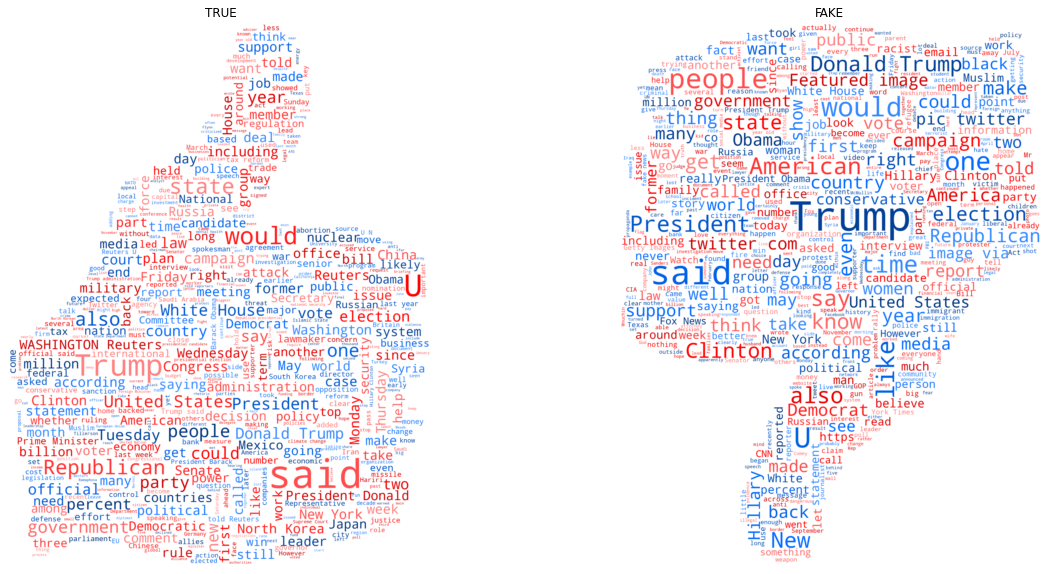

In [6]:
def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds

fig, axs = plt.subplots(1, 2,figsize=(20,10))  

axs[1].imshow(wordcloud_fake.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[1].axis("off")
axs[1].title.set_text('FAKE')
axs[0].imshow(wordcloud_true.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('TRUE')
plt.show()

In [ ]:
# Descargar el png, y subirla a la carpeta data.

In [25]:
testing_sample_size = 100 # Algunas operaciones se demoran mucho tiempo, este tamaño pequeño es para agilizarlas
sample_size = 5000
data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [14]:
porter = PorterStemmer()
stopwords_en_porter = [porter.stem(x) for x in stopwords_en]

In [15]:
def porter_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso de tokenización en la clase CountVectorizer
    para que se pueda obtener también la raíz de la palabra.'''
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [PorterStemmer().stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_porter] # remover las stopwords
    return words

In [16]:
import warnings
warnings.filterwarnings('ignore')
# Cuando se pasa un callable como argumento para modificar el comportamiento predeterminado de alguna etapa
# del preprocesamiento del texto del CountVectorizer se emite un warning. Por lo que investigamos a las
# stopwords que se pasen como argumento se les va a aplicar la misma función que se pasa como callable para
# pre procesarlas.

In [18]:
# Esta celda se demora un poco en ejecutarse
# La ventaja de este CountVectorizer customizado es que permite obtener la raíz de la palabra
customized_vectorizer= CountVectorizer(lowercase = True, strip_accents='unicode', \
                           tokenizer = porter_tokenizer, ngram_range = (1, 3), min_df = 3);
customized_vectorizer.fit(X_train)
customized_vectorizer_matrix = customized_vectorizer.transform(X_train)
customized_vectorizer_df = pd.DataFrame(customized_vectorizer_matrix.todense(), columns=customized_vectorizer.get_feature_names())
customized_vectorizer_df.head(2)

customized_vectorizer_test = customized_vectorizer.transform(X_test)

,1,1 million,10,10 year,100,10000,11,12,14,16,...,wrong,wrote,yard,ye,year,year ago,yet,york,young,youtub
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [19]:
tfidf_matrix = TfidfTransformer().fit_transform(customized_vectorizer_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = vectorizer.get_feature_names())
tfidf_df.head(2)

tfidf_matrix_test = TfidfTransformer().transform(customized_vectorizer_test)

,000,10,10 000,10 years,100,11,12,14,15,16,...,wrote,year,year old,years,yes,yet,york,young,youtu,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.044252,0.0,0.0,0.0,0.042777,0.0,0.0,0.0,0.0,0.0


In [20]:
def select_n_components(var_ratio, goal_var: float) -> int:
    ''' Esta función se utiliza para hacer un cambio de base y lograr explicar el porcentaje de los
    datos que se pasa en el argumento goal_var.
    Fuente https://chrisalbon.com/code/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
    Fue modificada para que hiciera un gráfico de la varianza explicativa del modelo de acuerdo al número
    de componentes'''
    # Set initial variance explained so far
    total_variance = 0.0
    # Set initial number of features
    n_components = 0
    # Listas del nuḿero de componentes y de la explicación de varianza alcanzada para poder graficarlas
    num_components = list(range(1, len(var_ratio) + 1))
    variances = []
    # For the explained variance of each feature:
    found_n_components = False
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        # Agregar la varianza explicada al listado 
        variances.append(total_variance)
        # If we reach our goal level of explained variance and we haven't reached our desired variance
        if total_variance >= goal_var and found_n_components == False:
            desired_n_components = n_components
            found_n_components = True
            desired_variance = total_variance
    plt.plot(num_components, variances)
    plt.scatter(desired_n_components, desired_variance, c = 'r')
    plt.xlabel('Número de componentes')
    plt.ylabel('Razón de la explicación de la varianza')
    plt.hlines(desired_variance, 0, desired_n_components, 'r', 'dashed')
    plt.vlines(desired_n_components, 0, desired_variance, 'r', 'dashed')
        
    # Return the desired number of components
    return desired_n_components

Número de componentes antes del cambio de base: 1842
Número de componentes después del cambio de base: 90
Hay 1752 componentes menos gracias al cambio de base


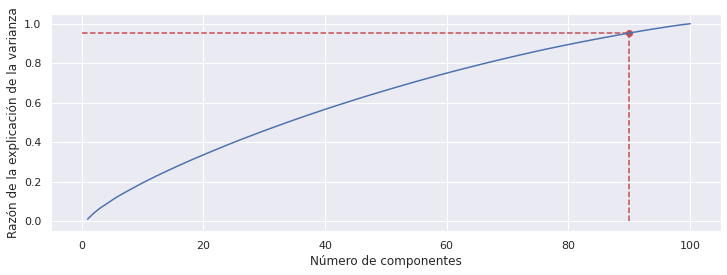

In [21]:
# Esta celda demora en ejecutarse
# Tener en cuenta que si el número de filas de la matrix esparsa es menor al número de componentes elegido
# como hiperparámetro, una vez que se haya realizado la transformación SVD el número de componentes 
# obtenido será igual al número de filas de la matriz esparsa, y no será el número de componentes
# elegido como hiperpárametro
test_svd = TruncatedSVD(n_components = tfidf_matrix.shape[1] - 1);
test_svd.fit(tfidf_matrix)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_threshold = 0.90
n_components = select_n_components(tsvd_var_ratios, desired_threshold)
n_components_dif = tfidf_df.shape[1] - n_components
print(f'Número de componentes antes del cambio de base: {tfidf_df.shape[1]}')
print(f'Número de componentes después del cambio de base: {n_components}')
print(f'Hay {n_components_dif} componentes menos gracias al cambio de base')

In [ ]:
# Esta celda demora en ejecutarse
# Evaluamos cómo responde el cambio de base cuando seleccionamos una explicación de la varianza mucho menor
test_svd = TruncatedSVD(n_components = tfidf_matrix.shape[1] - 1);
test_svd.fit(tfidf_matrix)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_threshold = 0.10
n_components = select_n_components(tsvd_var_ratios, desired_threshold)
n_components_dif = tfidf_df.shape[1] - n_components
print(f'Número de componentes antes del cambio de base: {tfidf_df.shape[1]}')
print(f'Número de componentes después del cambio de base: {n_components}')
print(f'Hay {n_components_dif} componentes menos gracias al cambio de base')

In [23]:
# Evaluar el comportamiento de la curva cuando hay 5k registros o más

In [24]:
# Esta celda demora en ejecutarse
svd = TruncatedSVD(n_components = n_components)
svd_matrix = svd.fit_transform(tfidf_matrix)
svd_df = pd.DataFrame(svd_matrix)
svd_df.head(2)

svd_test = svd.transform(tfidf_matrix_test)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.090205,0.147648,-0.078520,-0.071154,-0.002777,-0.023184,-0.075478,0.144411,0.062597,0.107516,...,0.070058,-0.009036,0.062173,-0.025437,0.029631,-0.008736,-0.033563,0.011493,0.038358,0.011377
1,0.492392,-0.253617,-0.009632,-0.176628,-0.078863,-0.124003,-0.041561,-0.159458,-0.090584,-0.094612,...,-0.103868,-0.031715,0.025749,0.127901,-0.056923,-0.057230,0.030317,-0.101212,-0.023878,0.077859


## Fature selection

# Modelos

In [ ]:
X_train = tfidf_df
X_test = tfidf_matrix_test

## Naive Bayes

In [11]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

0.902

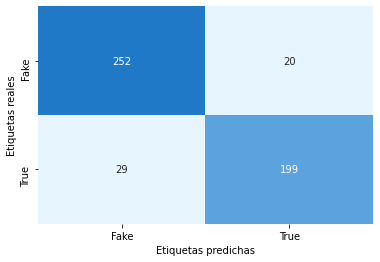

In [12]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
axis_labels = np.sort(y_test.unique())
cm_nb = confusion_matrix(y_test, NB_model.predict(X_test))
sns.heatmap(cm_nb, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

#### Modelo de Reg. Logistica

In [13]:
reg_model = LogisticRegression(C = 7, solver="saga", l1_ratio=0.5 , penalty="elasticnet", n_jobs=-1)
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

0.908

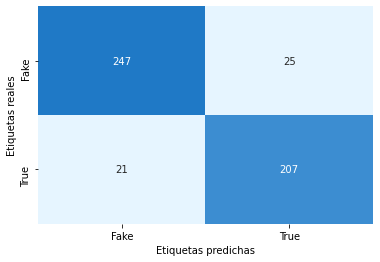

In [14]:
cm_rlog = confusion_matrix(y_test, reg_model.predict(X_test))
sns.heatmap(cm_rlog, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [15]:
X_train_dense = pd.DataFrame(X_train.todense(), 
             columns = count_vectorizer.get_feature_names()) 

Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=X_train_dense.columns, columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum() * Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')
Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

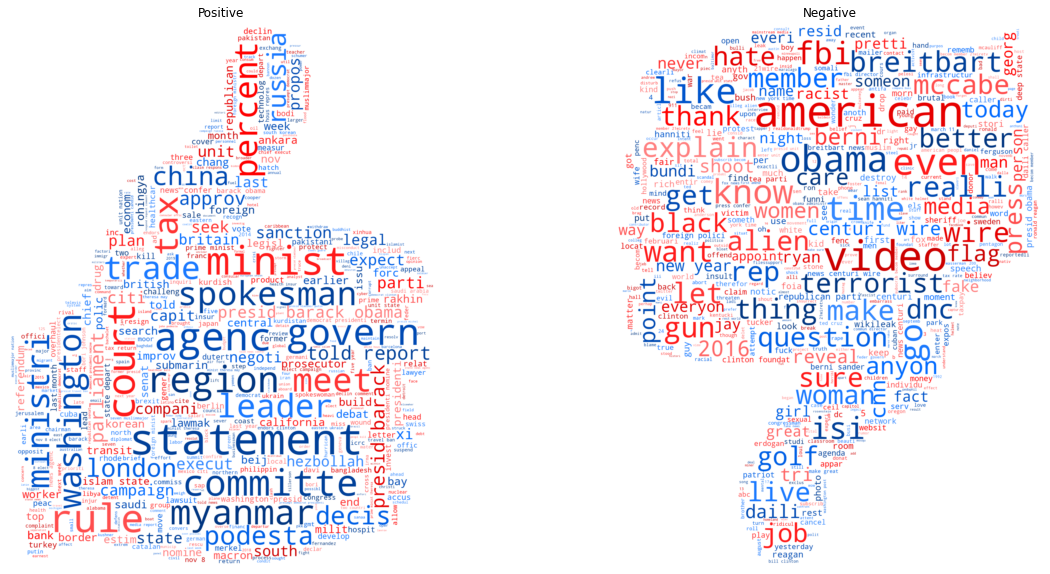

In [16]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_pos = np.array(Image.open(path.join(d, "Thumbs.png")))
mask_neg = np.array(Image.open(path.join(d, "Thumbsdw.png")))

wordcloud_positive = WordCloud(max_words=500, mask=mask_pos, background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=500, mask=mask_neg,background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

fig, axs = plt.subplots(1, 2,figsize=(20,10))
# Display the generated image:
axs[0].imshow(wordcloud_positive.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('Positive')
axs[1].imshow(wordcloud_negative.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[1].axis("off")
axs[1].title.set_text('Negative')
plt.show()

## Modelo de Reg. Logistica Truncando palabras

In [17]:
svd = TruncatedSVD(n_components = 300);

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [18]:
display(svd.explained_variance_ratio_.sum())

0.797100372173525

In [19]:
reg_model_svd = LogisticRegression(C = 8, solver="newton-cg", penalty="l2")
reg_model_svd.fit(X_train_svd, y_train)
reg_model_svd.score(X_test_svd, y_test)

0.924

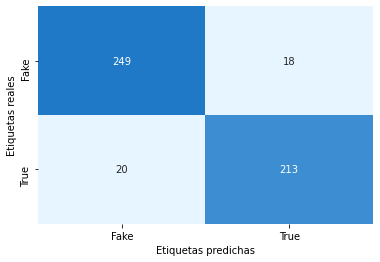

In [20]:
cm_rlog_svd = confusion_matrix(y_test, reg_model_svd.predict(X_test_svd))
sns.heatmap(cm_rlog_svd, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## Decision Tree Classifier

In [21]:
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train, y_train)
my_tree.score(X_test, y_test)

0.736

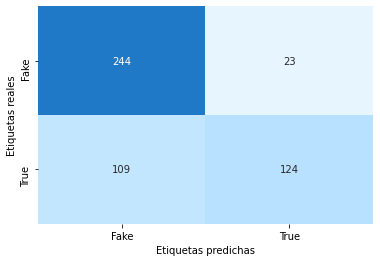

In [22]:
cm_tree = confusion_matrix(y_test, my_tree.predict(X_test))
sns.heatmap(cm_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

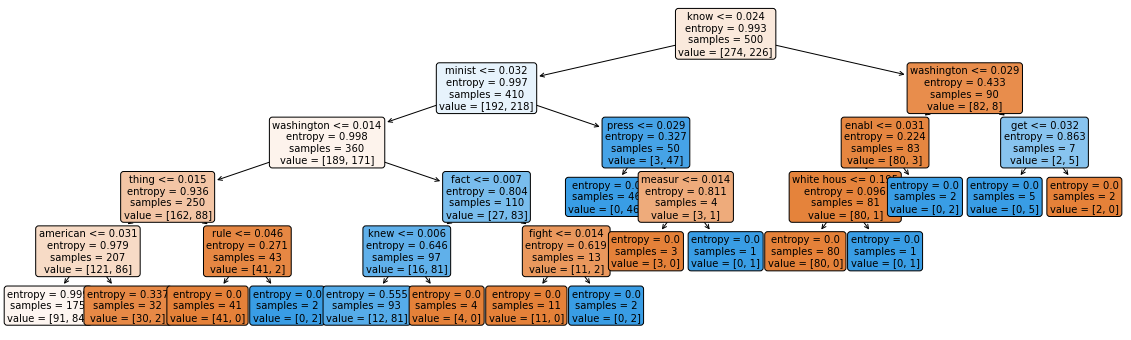

In [23]:
plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = X_train_dense.columns,filled=True,rounded=True, fontsize = 10)
plt.show()

## Boosting de Modelos

In [24]:
base_classifier = ExtraTreesClassifier(n_estimators=100, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

boost_tree = AdaBoostClassifier(base_estimator = base_classifier, 
                            n_estimators = 200,
                            learning_rate = 0.8,                                       
                            random_state = 127)

boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

0.926

Text(0.5, 15.0, 'Etiquetas predichas')

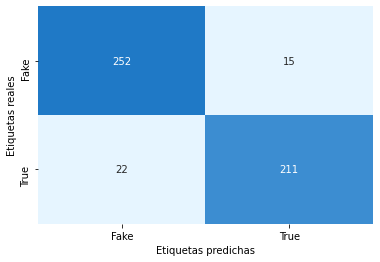

In [25]:
cm_boost_tree = confusion_matrix(y_test, boost_tree.predict(X_test))
sns.heatmap(cm_boost_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

## Pipeline

In [26]:
pasos = [('vectorizador', CountVectorizer(lowercase = True, strip_accents='unicode',\
                                          tokenizer = porter_tokenizer)), 
         ('tfidf', TfidfTransformer()), 
         ('cambio_base', TruncatedSVD(n_components)),
         ('modelo', MultinomialNB())]
pipeline = Pipeline(pasos)

In [27]:
param_grid = [{'vectorizador__lowercase': True ,
               'vectorizador__lowercase': True ,
                'vectorizador__ngram_range': [(1, 3), (2, 3), (3, 3), (1, 4), (2, 4), (3, 4), (4, 4)],
               'vectorizador__min_df': range(1, 4),
               'tfidf__norm': ['l1', 'l2'],
               'cambio_base': [TruncatedSVD(), None],
               #'cambio_base__n_componentes': [n_components, X_train.shape[1] - 1],
               'modelo': [MultinomialNB(), LogisticRegression(), DecisionTreeClassifier(), ExtraTreesClassifier()]}]

In [ ]:
# construir clase q metodo fit sea crear n_optimo. Tiene 3 casos, si None: N= None, elif max: n= shape[1] - 1, 
# else threshold: n = n_optimo
# Transform n = None no ahce nada, n = num hace la reducción de la dimensionalidad
# Generar transformer que tenga hiperparametro true y false, si true hace cuenta y reduce dimensionalidad a nro optimo
# en false shape-1

In [28]:
# Este toma menos tiempo
param_grid2 = [{#'vectorizador__ngram_range': [(1, 3), (2, 3), (3, 3), (1, 4), (2, 4), (3, 4), (4, 4)],
               #'vectorizador__min_df': range(1, 4),
               #'tfidf__norm': ['l1', 'l2'],
               'cambio_base': [TruncatedSVD(), None],
               'cambio_base__n_componentes': [n_components, X_train.shape[1] - 1],
               'modelo': [MultinomialNB(), LogisticRegression()]}]

In [29]:
# Apróximadamente toma 10 min la ejecución con un sample de 1000 records y param_grid2
folds=StratifiedKFold(n_splits=5,shuffle=True)
grid = GridSearchCV(pipeline, param_grid2, cv = folds)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizador',
                                        CountVectorizer(strip_accents='unicode',
                                                        tokenizer=<function porter_tokenizer at 0x7f72cf9ef3a0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('cambio_base',
                                        TruncatedSVD(n_components=90)),
                                       ('modelo', MultinomialNB())]),
             param_grid=[{'cambio_base': [TruncatedSVD(), None],
                          'modelo': [MultinomialNB(), LogisticRegression()]}])

In [30]:
grid.best_score_

0.525

In [31]:
grid.best_estimator_

Pipeline(steps=[('vectorizador',
                 CountVectorizer(strip_accents='unicode',
                                 tokenizer=<function porter_tokenizer at 0x7f72cf9ef3a0>)),
                ('tfidf', TfidfTransformer()), ('cambio_base', None),
                ('modelo', LogisticRegression())])

In [32]:
grid.best_params_

{'cambio_base': None, 'modelo': LogisticRegression()}

## Pipeline con título de las noticias (SIN contenido del texto)

In [ ]:
# Hacer el pipeline sólamente con los títulos de las noticias para ver qué pasa

## A traves de webscraping se buscan noticias para obtener más datos de testing

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

def get_text_from_url_bbc(url):
    wd.get(url)

    time.sleep(1)

    soup = BeautifulSoup(wd.page_source)
    text = soup.find_all('div', {'data-component': 'text-block'}) #(?P<text>\>(.*?)\<)
    text = reversed(text) 
    text2 = ""
    for i in text:
        try:
            text2 = i.text+text2
        except:
            text2 = ""+text2
    return text2    

In [ ]:

warnings.filterwarnings("ignore")
#https://newsapi.org/docs
response = requests.get("https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=1f83e742c8804de0a5d427510829f79b")

list_urls = []
for i in range(0,len(response.json()['articles'])):
    list_urls.append(response.json()['articles'][i]['url'])  
    
list_texts = []
for i in range(0,len(list_urls)):
    list_texts.append(get_text_from_url_bbc(list_urls[i]))

In [ ]:
data_texts_text = pd.DataFrame(list_texts, columns=['text'])
data_texts_text['len'] = data_texts_text.text.apply(lambda x: len(x))
data_texts_text['real'] = 'True'
data_texts_text = data_texts_text[data_texts_text.len>0]
clean_texts_test = data_texts_text.text.progress_apply(lambda x: clean_review(x, tokenizer, englishStemmer, stopwords_en_stem))

X_test_sparse_texts = count_vectorizer.transform(clean_texts_test)
X_test_texts = pd.DataFrame(X_test_sparse_texts.todense(), 
             columns = count_vectorizer.get_feature_names()) 
X_test_svd_texts = svd.transform(X_test_texts)
X_test_bigram_sparse_texts = count_vectorizer_bigram.transform(clean_texts_test)

In [ ]:
data_texts_text['predict_reg_base'] = reg_model.predict(X_test_texts)
data_texts_text['predict_prob_reg_base'] = reg_model.predict_proba(X_test_texts).T[0]

data_texts_text['predict_svd'] = reg_model_svd.predict(X_test_svd_texts)
data_texts_text['predict_prob_svd'] = reg_model_svd.predict_proba(X_test_svd_texts).T[0]

data_texts_text['predict_bigram'] = reg_model_bigram.predict(X_test_bigram_sparse_texts)
data_texts_text['predict_prob_bigram'] = reg_model_bigram.predict_proba(X_test_bigram_sparse_texts).T[0]

data_texts_text['predict_my_tree'] = my_tree.predict(X_test_texts)
data_texts_text['predict_prob_my_tree'] = my_tree.predict_proba(X_test_texts).T[0]

data_texts_text

In [ ]:
X_train_explainer = np.array(X_train)
explainer = LimeTabularExplainer(X_train_explainer, 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = X_train.columns,
                                 discretize_continuous=False)

#i = 13
#data_row = np.array(X_test.iloc[i])
data_row = np.array(X_test_texts.iloc[4])
explanation = explainer.explain_instance(data_row, reg_model.predict_proba, num_features=10)
explanation.as_pyplot_figure();

In [ ]:
data_texts_text.text.iloc[4]